<a href="https://colab.research.google.com/github/armandoordonez/eda_couse/blob/main/3-Tutorial_Descomposición-Series-De-Tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TUTORIAL: DESCOMPOSICIÓN DE SERIES DE TIEMPO

En este tutorial veremos cómo usar la librería *statsmodels* de Python para hacer lo que se conoce como la descomposición de la serie de tiempo.

Contenido:
1. [Repaso: componentes de una serie de tiempo](#scrollTo=KHeXzLN6kKdt)
2. [Introducción a la librería *statsmodels*](#scrollTo=SYhcpu9gpfGe)
3. [Los sets de datos](#scrollTo=DgB6ZKHZuAu5&line=8&uniqifier=1)
4. [Descomposición clásica](#scrollTo=aIOmmVjiwqpQ&line=25&uniqifier=1)
5. [Descomposición STL](#scrollTo=vLYG01qV224r&line=16&uniqifier=1)

## 1. Repaso: componentes de una serie de tiempo

En videos anteriores hemos hablado de los principales componentes de una serie de tiempo: [la estacionalidad](https://youtu.be/6vTqWHShwpI), [el nivel y la tendencia](https://youtu.be/FD9JLm_4Kkg).

Sugiero ver esos videos para entender todos los detalles, aunque a continuación haremos un breve repaso:

> **Estacionalidad:** una serie de tiempo tiene estacionalidad cuando alcanza picos y valles que se repiten periódicamente y de manera predecible en el tiempo

![](https://drive.google.com/uc?export=view&id=1vi57KcaOrsMo8T15ulq0RpPqKHRgABpW)

> **Nivel:** es el valor promedio de la serie a lo largo del tiempo

![](https://drive.google.com/uc?export=view&id=1vj34p1GEvPJBvBjLxPSkbirjthEvUS95)

> **Tendencia:** es un nivel en la serie pero que cambia a lo largo del tiempo

![](https://drive.google.com/uc?export=view&id=1vknQzawFoxA28JRqkPqJ9BW5MgdCiXxH)

La importancia de conocer estos componentes radica en que nos permiten:

- Analizar o caracterizar la serie de tiempo
- Construir modelos predictivos clásicos a partir de dichos componentes

## 2. Introducción a la librería *statsmodels*

> [*statsmodels*](https://www.statsmodels.org/stable/index.html) es una librería de Python que permite analizar datos usando métodos estadísticos así como construir modelos estadísticos.

Y para el caso de series de tiempo es una librería que permite realizar pre-procesamiento, descomposición e implementar modelos predictivos.

En este tutorial nos enfocaremos precisamente en dos de los principales métodos disponibles en la librería: los métodos clásicos y los métodos STL (*Seasonal and Trend decomposition using Loess*)

## 3. Los sets de datos

Usaremos dos sets de datos para entender las diferentes maneras de descomponer una serie de tiempo con *statsmodels*:

- *niveles_co2.csv*: registro histórico de niveles de CO2 a nivel mundial entre 1958 y 2001 (2.284 registros)
- *flujo_pasajeros.csv*: registros del flujo de pasajeros en diferentes aerolíneas de Estados Unidos entre 1949 y 1960 (144 registros)

Comencemos leyendo y visualizando cada set de datos:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
# Leer dataset niveles_co2 como serie de tiempo
co2 = pd.read_csv('https://raw.githubusercontent.com/armandoordonez/eda_couse/main/data/niveles_co2.csv',
                  parse_dates=True,
                  index_col='fecha')

co2

,co2
fecha,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2


In [4]:
# Visualización set de datos CO2
fig = px.line(co2)
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


Algunas observaciones importantes sobre este set de datos:

- Tiene una tendencia creciente a lo largo del tiempo
- Pero además tiene estacionalidad con una periodicidad aproximada de 12 meses

Veamos ahora el set *flujo_pasajeros.csv*:

In [6]:
# Leer dataset flujo_pasajeros como serie de tiempo
pasaj = pd.read_csv('https://raw.githubusercontent.com/armandoordonez/eda_couse/main/data/flujo_pasajeros.csv',
                    parse_dates=True,
                    index_col='fecha')

pasaj

,pasajeros
fecha,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461


In [7]:
# Visualización set de datos pasajeros
fig = px.line(pasaj)
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Y algunas observaciones sobre este set de datos:

- Tiene una tendencia creciente
- Pero además tiene una estacionalidad **creciente**: los máximos/mínimos se repiten periódicamente (aproximadamente cada 12 meses) pero estos máximos/mínimos son cada vez más grandes/pequeños

Estas observaciones hechas para ambos sets de datos serán claves al momento de la descomposición.

##4. Descomposición clásica

La idea de la descomposición clásica es expresar la serie de tiempo ($y(t)$) como una combinación de tres componentes:

- $S(t)$: estacionalidad
- $T(t)$: tendencia
- $R(t)$: residual (componente de error asociado a la descomposición)

La lógica de funcionamiento de estos métodos es sencilla:

1. Se usa la media móvil para estimar $T(t)$
2. Se usa la media móvil o suavizado exponencial para estimar $S(t)$
3. $R(t)$ se calcula a partir de la serie original ($y(t)$) y de los componentes $T(t)$ y $S(t)$ estimados en (1) y (2)

Y en estos métodos existen esencialmente dos maneras de expresar esta descomposición:

- *Descomposición aditiva*:

$$y(t) = S(t) + T(t) + R(t)$$

Esta descomposición es "adecuada" cuando la magnitud del componente estacional **se mantiene relativamente** constante a pesar de la tendencia (como en el caso de la serie del CO2).

- *Descomposición multiplicativa*:

$$y(t) = S(t) \cdot T(t) \cdot R(t)$$

Esta descomposición es "adecuada" cuando la magnitud del componente estacional **cambia proporcionalmente** con la tendencia (como en el caso de la serie del flujo de pasajeros).

Para realizar esta descomposición clásica con `statsmodels` debemos usar el módulo `seasonal_decompose` y en el parámetro `model` debemos especificar si haremos la descomposición con un modelo aditivo (`model='additive'`) o multiplicativo (`model='multiplicative`).

Por ejemplo, tomemos la serie de tiempo del CO2 y hagamos la descomposición aditiva:

In [8]:
# Descomposición de la serie CO2
from statsmodels.tsa.seasonal import seasonal_decompose

co2_comps_add = seasonal_decompose(co2,model='additive')

La variable `co2_comps_add` contendrá los diferentes elementos de la descomposición así como la serie original:

- Atributo `observed`: serie de tiempo original
- Atributo `seasonal`: componente estacional
- Atributo `trend`: tendencia
- Atributo `resid`: residuales

In [9]:
co2_comps_add.

SyntaxError: invalid syntax (<ipython-input-9-3fb13a4fb393>, line 1)

Además, la variable `co2_comps_add` tendrá el método `plot()` que permite fácilmente generar una gráfica de la serie de tiempo original y de sus componentes:

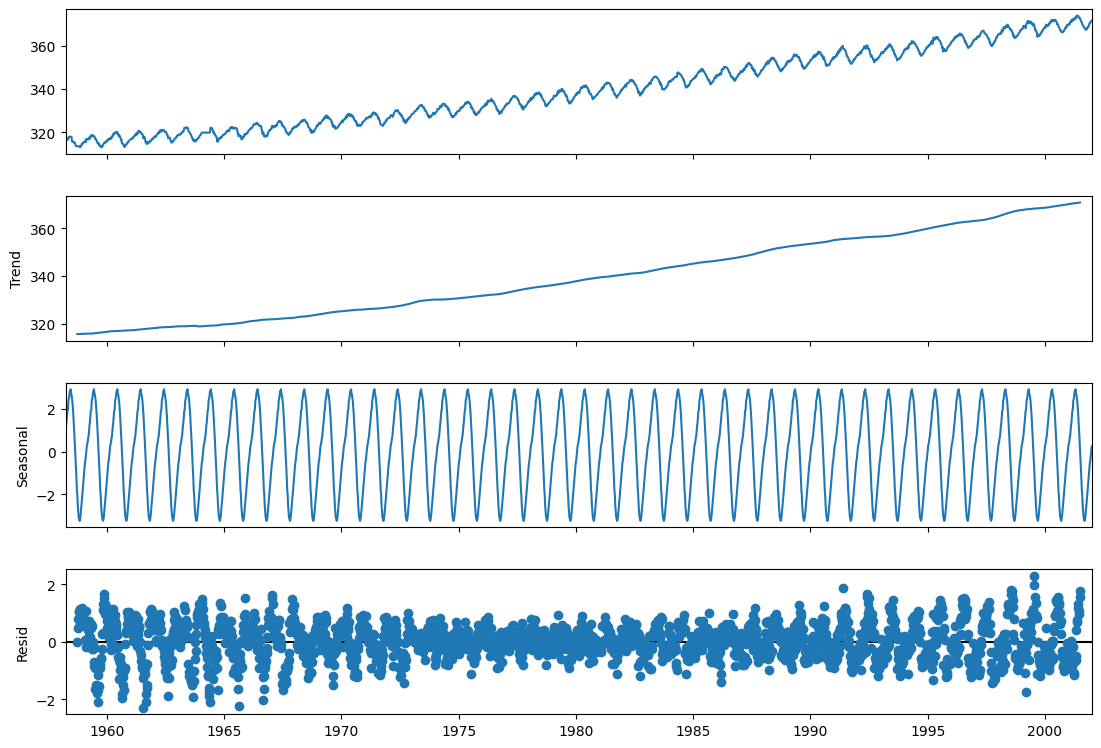

In [10]:
fig=co2_comps_add.plot()
fig.set_size_inches((12, 8))

Y podemos ver por ejemplo cómo la tendencia se ha venido incrementando desde 320 (ppm) a finales de los 50s hasta casi 370 (ppm) comienzos de los 2000. Además vemos que el componente estacional tiene una periodicidad de aproximadamente 1 año.

En este caso el componente estacional de la serie preserva su magnitud a lo largo del tiempo lo cual quiere decir que la descomposición aditiva es más adecuada.

Veamos el promedio del error en la descomposición en este caso:

In [ ]:
print(f'Promedio residuales descomposición aditiva: {co2_comps_add.resid.mean()}')

Promedio residuales descomposición aditiva: 0.003863928260184549


Y comparemos este resultado con el promedio del error en la descomposición multiplicativa:

In [ ]:
co2_comps_mult = seasonal_decompose(co2,model='multiplicative')

print(f'Promedio residuales descomposición multiplicativa: {co2_comps_mult.resid.mean()}')

Promedio residuales descomposición multiplicativa: 1.0000070468141424


Efectivamente el error es menor con la descomposición aditiva y por tanto los componentes de tendencia y estacionalidad capturan mejor las variaciones presentes en la serie.

Veamos ahora qué ocurre con la serie del flujo de pasajeros que, como vimos hace un momento, tiene una estacionalidad cuya magnitud se incrementa con el tiempo. Por tanto, resulta más adecuado usar una descomposición multiplicativa:

Promedio residuales descomposición multiplicativa: 0.9982356582764101
Promedio residuales descomposición aditiva: -0.7512626262626092


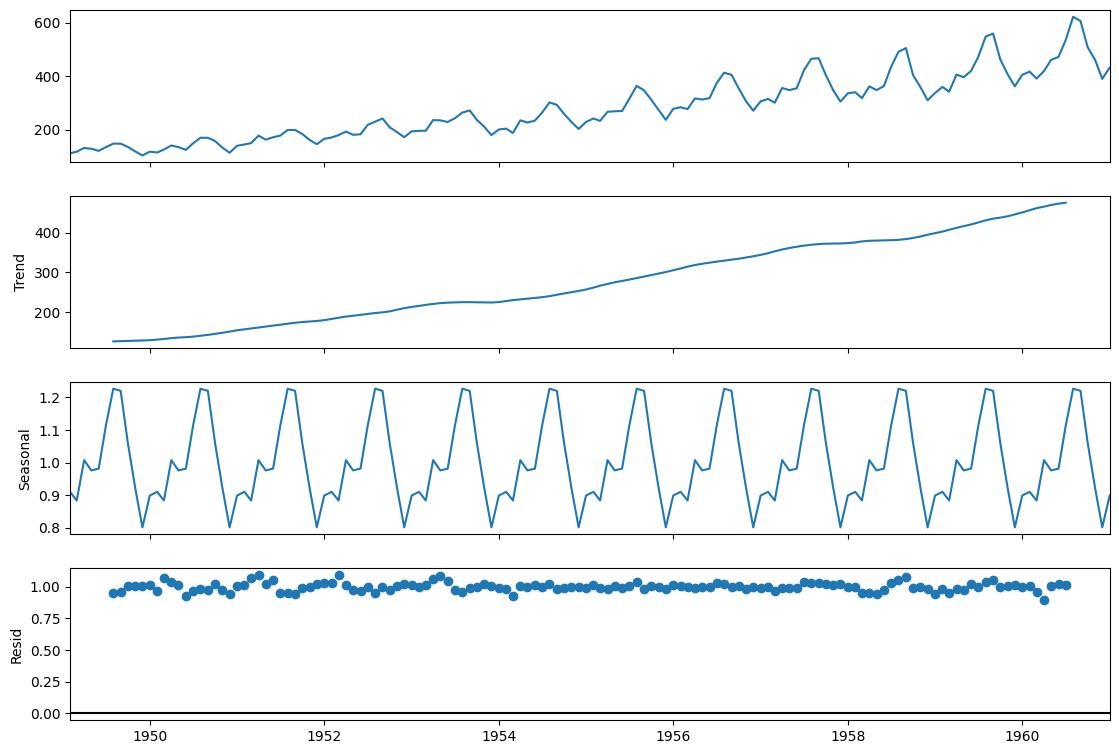

In [ ]:
# Descomposición multiplicativa
pasaj_comps_mult = seasonal_decompose(pasaj,model='multiplicative')

# Graficar descomposición
fig=pasaj_comps_mult.plot()
fig.set_size_inches((12, 8))

# Imprimir en pantalla promedio de los residuales
print(f'Promedio residuales descomposición multiplicativa: {pasaj_comps_mult.resid.mean()}')

# Y comparar el resultado anterior con los residuales de la descomposición aditiva
pasaj_comps_add = seasonal_decompose(pasaj,model='aditive')
print(f'Promedio residuales descomposición aditiva: {pasaj_comps_add.resid.mean()}')

Vemos que a pesar de que la magnitud del componente estacional tiende a crecer en la práctica es la descomposición con menor error es la aditiva.

Así que la sugerencia es:

> Realizar la descomposición con los dos métodos y tomar aquella para la cual el promedio de los residuales sea menor

## 5. Descomposición STL

Las siglas en el nombre de esta descomposición corresponden a "Seasonal and Trend decomposition using Loess".

En últimas esta descomposición también permite obtener los tres componentes (tendencia, estacionalidad y residuales) pero usa un método más sofisticado que la descomposición clásica.

La idea básica es:

1. Se estima la estacionalidad de la serie usando lo que se conoce como "local regression (Loess)": se promedian "N" datos vecinos (donde "N" depende de la periodicidad aproximada de la serie)
2. Habiendo estimado la estacionalidad se elimina de la serie original (*Serie resultante = serie original - estacionalidad*) y como resultado se tendría la tendencia y el ruido en la serie
3. A la serie que resulta en (2) se le aplica nuevamente el método Loess con un "N" diferente al usado al estimar la estacionalidad. Con esto se determinan las variaciones a largo plazo de la serie (es decir la tendencia)
4. Finalmente el residual será el resultado de tomar la serie original y restarle la estacionalidad (paso 1) y la tendencia (paso 3)

En general este método produce mejores descomposiciones en comparación con el método clásico (es más robusto).

Veamos por ejemplo cómo descomponer la serie de tiempo del CO2:

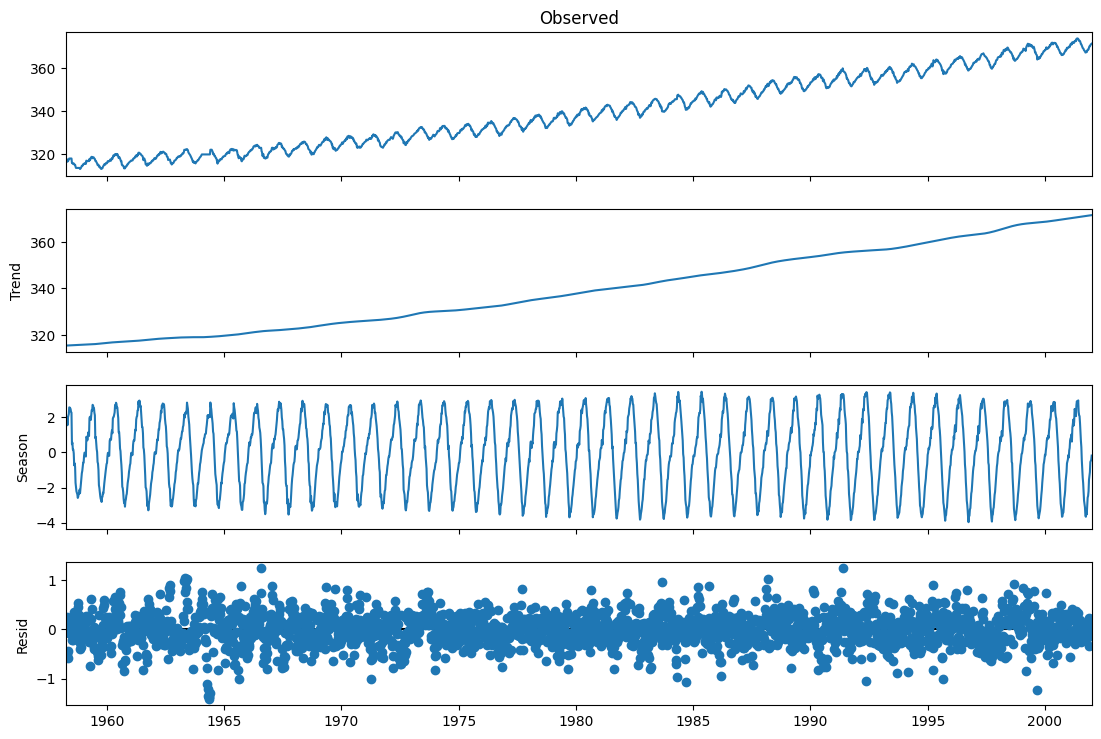

In [ ]:
# Importar módulo STL
from statsmodels.tsa.seasonal import STL

# Realizar descomposición STL
co2_stl = STL(co2).fit()

# Y generar gráficas
fig = co2_stl.plot()
fig.set_size_inches((12,8))

Veamos en este caso el valor promedio de los residuales y comparémoslo con los residuales obtenidos con las descomposiciones aditiva y multiplicativa:

In [ ]:
print(f'Promedio residuales descomposición aditiva: {co2_comps_add.resid.mean()}')
print(f'Promedio residuales descomposición multiplicativa: {co2_comps_mult.resid.mean()}')
print(f'Promedio residuales descomposición STL: {co2_stl.resid.mean()}')

Promedio residuales descomposición aditiva: 0.003863928260184549
Promedio residuales descomposición multiplicativa: 1.0000070468141424
Promedio residuales descomposición STL: -0.0014306865172750657


Efectivamente con el método STL los residuales son menores.

Hagamos lo mismo pero para la serie del flujo de pasajeros:

Promedio residuales descomposición aditiva: -0.7512626262626092
Promedio residuales descomposición multiplicativa: 0.9982356582764101
Promedio residuales descomposición STL: -0.16863466812152428


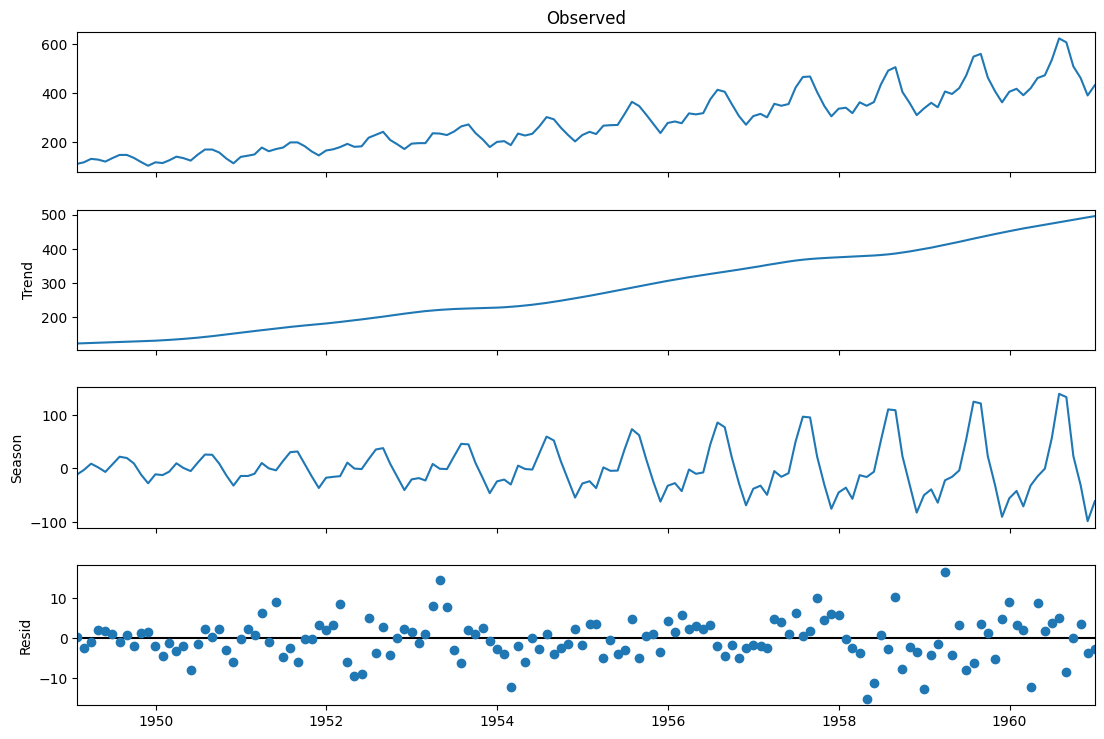

In [ ]:
# Realizar descomposición STL
pasaj_stl = STL(pasaj).fit()

# Generar gráficas
fig = pasaj_stl.plot()
fig.set_size_inches((12,8))

# E imprimir comparativos de los residuales
print(f'Promedio residuales descomposición aditiva: {pasaj_comps_add.resid.mean()}')
print(f'Promedio residuales descomposición multiplicativa: {pasaj_comps_mult.resid.mean()}')
print(f'Promedio residuales descomposición STL: {pasaj_stl.resid.mean()}')

Y de nuevo los residuales son menores en la descomposición STL y por tanto la descomposición es más precisa.

Vemos por ejemplo en este caso que la descomposición STL sí captura el incremento en la magnitud del componente estacional a lo largo del tiempo.